# Learning with a neural network and localized augmentation

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Import
import logging
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pssl
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Config
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble= r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')


logging_config = {}
logging_config['level'] = logging.INFO
logging.StreamHandler(sys.stdout)

logging.basicConfig(**logging_config)
logging.getLogger('matplotlib.font_manager').disabled = True
logger = logging.getLogger("pssl")

In [39]:
from pssl.architecture import MLP
from pssl.datasets import AugmentedHalfMoonDataset, HalfMoonDataset
from pssl.loss import augmented_ortho_reg, fixed_augmentation_diff
from pssl.auxillary import training

In [54]:
class SimpleClass:
    def __init__(self):
        pass

config = SimpleClass
config.n_train = 1000
config.views = 2
config.sigma = .1
# New
config.epsilon = .1

config.in_dim = 2
config.mlp_units = [100, 20]
config.out_dim = 1

config.lr = 5e-3
config.momentum = 0
config.weigth_decay = 0

config.batch_size = 4
config.gamma = .3
config.nb_epochs = int(5e1)

config.lambda_reg = 1

nb_batch = config.n_train // config.batch_size
DEVICE = 'cpu'
DTYPE = torch.float32
NP_DTYPE = np.float32

In [55]:
dataset = AugmentedHalfMoonDataset(
    n = config.n_train, sigma=config.sigma, epsilon=config.epsilon, m=config.views, device=DEVICE, dtype=DTYPE
)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [56]:
# Architecture and optimizer
net = MLP(
    [config.in_dim, *config.mlp_units, config.out_dim], device=DEVICE, dtype=DTYPE
)
optimizer = optim.SGD(
    net.parameters(),
    lr=config.lr,
    momentum=config.momentum,
    weight_decay=config.weigth_decay,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, config.nb_epochs * nb_batch / 3, gamma=config.gamma
)

In [57]:
training(
    net,
    dataloader,
    fixed_augmentation_diff,
    optimizer,
    regularizer=augmented_ortho_reg,
    scheduler=scheduler,
    lambda_reg=config.lambda_reg,
    nb_epochs=config.nb_epochs,
)


# def loss_function(net, inputs, outputs=None, **kwargs):
#     return ortho_reg(outputs, centered=True)
# training(
#     net,
#     dataloader,
#     loss_function,
#     optimizer,
#     loss_kwargs={
#         "sigma_augmentation": .1,
#     },
#     scheduler=scheduler,
#     nb_epochs=config.nb_epochs,
# )

INFO:aux-optim:[1] loss: 0.054 = 0.010 + 1.000 * 0.044
INFO:aux-optim:[2] loss: 0.004 = 0.002 + 1.000 * 0.003
INFO:aux-optim:[3] loss: 0.002 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[4] loss: 0.002 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[5] loss: 0.001 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[6] loss: 0.001 = 0.001 + 1.000 * -0.000
INFO:aux-optim:[7] loss: 0.002 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[8] loss: 0.003 = 0.001 + 1.000 * 0.002
INFO:aux-optim:[9] loss: 0.002 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[10] loss: 0.001 = 0.000 + 1.000 * 0.000
INFO:aux-optim:[11] loss: 0.000 = 0.000 + 1.000 * 0.000
INFO:aux-optim:[12] loss: 0.001 = 0.000 + 1.000 * 0.000
INFO:aux-optim:[13] loss: 0.001 = 0.000 + 1.000 * 0.000
INFO:aux-optim:[14] loss: 0.000 = 0.000 + 1.000 * 0.000
INFO:aux-optim:[15] loss: 0.001 = 0.001 + 1.000 * 0.001
INFO:aux-optim:[16] loss: 0.002 = 0.000 + 1.000 * 0.002
INFO:aux-optim:[17] loss: 0.003 = 0.001 + 1.000 * 0.002
INFO:aux-optim:[18] loss: 0.003 = 0.001 + 1.000 * 0.003


In [58]:
net.eval()

num = 100
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, num=num), np.linspace(-1.5, 2.5, num=num))
x_test = np.vstack((X.flatten(), Y.flatten())).T.astype(NP_DTYPE)
tox = torch.from_numpy(x_test).to(DEVICE)
with torch.no_grad():
    Z = net(tox).cpu().numpy()
    Z -= np.mean(Z, axis=0)

In [59]:
# Training set visualization
def halfmoon(n, noise_level=.1):
    theta = np.random.rand(n)
    theta *= 2 * np.pi
    x = np.empty((n, 2), dtype=float)
    x[:, 0] = np.cos(theta)
    x[:, 1] = np.sin(theta)
    x[x[:, 0] > 0, 1] += 1 
    x += noise_level * np.random.randn(n, 2)
    return x
    

def noise_augmentations(x, eps=.1):
    xi = np.hstack((x, x)).reshape(-1, 2)
    xi += eps * np.random.randn(*xi.shape)
    return xi


np.random.seed(0)
# xi = noise_augmentations(halfmoon(100))

xi = dataset.xi.reshape(-1, 2).numpy()

# Visualization
def plot_pairs(ax, xi=xi, **kwargs):
    for i in range(xi.shape[0]//2):
        ax.plot(xi[2*i:2*(i+1), 0], xi[2*i:2*(i+1), 1], **kwargs)

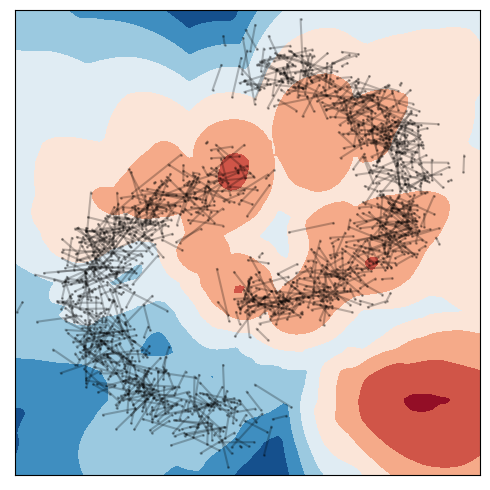

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_pairs(ax, xi, marker='.', markersize=2, c='k', alpha=.25)
ax.contourf(X, Y, Z[:, 0].reshape(*X.shape), cmap='RdBu_r')
ax.tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
fig.frameon = False
fig.tight_layout()
fig.savefig('nn.pdf')